## Conditional Generative Adverserial Network

In [ ]:
from IPython.display import Image
%matplotlib inline

### Using Conditional GAN for MNIST dataset


The primary difference between a **DCGAN** (Deep Convolutional GAN) and a **Conditional DCGAN (cDCGAN)** lies in the use of **conditioning information**. Let’s break down these distinctions clearly:

#### 1. **Core Idea**
   - **DCGAN**: A DCGAN generates images without any control over the content. It generates realistic-looking samples based solely on random noise input, learning to mimic the distribution of a dataset without any particular focus on classes or categories.
   - **Conditional DCGAN (cDCGAN)**: A cDCGAN generates images conditioned on specific labels or auxiliary information. For example, on the MNIST dataset, a cDCGAN can be trained to generate images of specific digits (0-9) by providing label information (the digit) along with the noise vector.

#### 2. **Generator Architecture**
   - **DCGAN Generator**: Takes a random noise vector as input and transforms it through a series of convolutional layers to generate an image. It does not take any class information, so there’s no control over what type of image (e.g., which digit) it generates.
   - **cDCGAN Generator**: In addition to the noise vector, the generator receives a **label embedding** that represents the conditioning information (e.g., digit label 0-9). The noise and label embedding are concatenated and fed together through the generator’s convolutional layers. This allows the generator to create images specific to the input label.

#### 3. **Discriminator Architecture**
   - **DCGAN Discriminator**: The DCGAN discriminator only receives an image (either real or generated) as input and learns to classify it as real or fake. It does not consider any additional information about the image's content.
   - **cDCGAN Discriminator**: The cDCGAN discriminator receives both an image and its corresponding label as input. The label is embedded and concatenated with the image data. This setup helps the discriminator to determine if the generated image is not only realistic but also matches the provided label, making it a more nuanced judge in the adversarial process.

![Example of Conditional GAN](https://machinelearningmastery.com/wp-content/uploads/2019/05/Example-of-a-Conditional-Generator-and-a-Conditional-Discriminator-in-a-Conditional-Generative-Adversarial-Network-1024x887.png)

##### **Conditional Probability Distributions**

- **Real Data Distribution:** $ p_{\text{data}}(x | y) $
- **Generator's Distribution:** $ p_G(x | y) $

The $x$ and $y$ could be thought of as channels in the image, and $y$ could be thought of as the class label embedded as another channel. (This is one of the way of implementing cGANs.)

##### **Objective Function**

The value function $ V(G, D) $ for a cGAN is defined as:

$$
\min_G \max_D V(G, D) = \mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D(x | y)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z | y) | y))]
$$


#### 4. **Loss Function**
In cGANs, both the Generator and the Discriminator are conditioned on $y$. The loss functions are modified to incorporate this conditioning, allowing the model to learn the joint distribution of data and conditioning variables.

##### **Discriminator Loss**

The Discriminator aims to maximize the probability of correctly classifying real and generated data. The loss function for the Discriminator $D$ is:

$$
\mathcal{L}_D = -\mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D(x | y)] - \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z | y) | y))]
$$

##### **Generator Loss**

The Generator tries to minimize the probability that the Discriminator correctly identifies its outputs as fake. The loss function for the Generator $ G $ is:

$$
\mathcal{L}_G = -\mathbb{E}_{z \sim p_z(z)} [\log D(G(z | y) | y)]
$$

Alternatively, to improve gradient flow, the Generator's loss can be formulated using the **least squares loss** or other variations.

---

### 5. Combining the Loss Functions

The training of a cGAN involves optimizing both $ G $ and $ D $ simultaneously. However, since $ G $ and $ D $ have opposing objectives, their loss functions are optimized alternately:

1. **Update Discriminator $ D $:** Maximize $ \mathcal{L}_D $
2. **Update Generator $ G $:** Minimize $ \mathcal{L}_G $

The losses are combined in the sense that the optimization of one depends on the performance of the other. However, they are not summed together; instead, they are used to update their respective networks during training iterations.

---




#### 6. **Training Objective**
   - **DCGAN**: Trains the generator to produce images that look as real as possible, while the discriminator is trained to differentiate between real and fake images.
   - **cDCGAN**: Trains the generator not only to create realistic images but also to create images that match the specified class label. The discriminator is trained to recognize if the image aligns with the label, adding a **class-matching constraint** on top of the real-vs-fake classification.

##### **Training Process**

1. **Discriminator Update:**

   - **Goal:** Maximize $ V(G, D) $ with respect to $ D $
   - **Loss Function:**
    
$$
\mathcal{L}_D = -\left( \mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D(x | y)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z | y) | y))] \right)
$$

   - **Optimization:** Update $ D $ to minimize $ \mathcal{L}_D $

2. **Generator Update:**

   - **Goal:** Minimize $ V(G, D) $ with respect to $ G $
   - **Loss Function:**

$$
\mathcal{L}_G = -\mathbb{E}_{z \sim p_z(z)} [\log D(G(z | y) | y)]
$$

   - **Optimization:** Update $ G $ to minimize $ \mathcal{L}_G $

#### 7. **Applications and Benefits**
   - **DCGAN**: Useful for general image generation tasks where specific control over the image content isn’t required. It’s often used for tasks like unsupervised feature learning and image generation in unstructured datasets.
   - **cDCGAN**: Useful when specific control over the image content is needed, such as generating images of specific categories or classes. Conditioning information provides control, making it ideal for applications like digit generation in MNIST, where you may want to generate images of a specific digit (0-9), or face generation, where specific attributes can be targeted.

#### Summary Table

| Feature                    | DCGAN                                    | Conditional DCGAN (cDCGAN)                              |
|----------------------------|------------------------------------------|--------------------------------------------------------|
| **Input to Generator**     | Noise vector                             | Noise vector + label embedding                         |
| **Input to Discriminator** | Image                                    | Image + label embedding                                |
| **Output Control**         | Random (no control over class/type)      | Controlled by label (e.g., generates specific digits)  |
| **Generator’s Goal**       | Generate realistic images                | Generate realistic images of a specific class          |
| **Discriminator’s Goal**   | Distinguish real vs. fake images         | Distinguish if the image is real and matches the label |

---



In [ ]:
import torch


print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

2.5.0+cu121
GPU Available: True


In [ ]:
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Train the DCGAN model

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

batch_size = 128
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 43.0MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.15MB/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:

# Generator network with conditioning (for cDCGAN)
class ConditionalGenerator(nn.Module):
    def __init__(self, z_dim, n_classes, n_filters):
        super(ConditionalGenerator, self).__init__()

        # Embedding layer for labels:
        # This embedding converts each label (e.g., digit 0-9 for MNIST) into a feature vector.
        # This feature vector will be combined with the noise input, enabling the generator
        # to control which class of image it generates.

        self.label_embedding = nn.Embedding(n_classes, z_dim)

        # Main Generator Network:
        # The network follows a similar architecture to DCGAN, using transposed convolutions.
        # However, the input size is modified to accommodate the concatenated noise and label embedding.
        self.model = nn.Sequential(
            # Input layer (z_dim + z_dim) because noise and label embedding are concatenated
            nn.ConvTranspose2d(z_dim + z_dim, n_filters * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(n_filters * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Additional transposed convolutional layers for upsampling to the desired image size
            nn.ConvTranspose2d(n_filters * 4, n_filters * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(n_filters * 2, n_filters, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer outputting a single channel image with values normalized to [-1, 1]
            nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Conditional Input Preparation:
        # Unlike DCGAN, where only noise is used, here we add label information.
        # Each label (digit 0-9) is converted to a vector using the embedding layer.
        # This vector is then reshaped to match the spatial dimensions of the noise.
        label_embedding = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)

        # Concatenate noise and label embedding along the channel dimension:
        # In cDCGAN, the input to the generator includes both the noise and the label embedding.
        # This concatenation allows the generator to produce images tailored to the specific label.
        input = torch.cat([noise, label_embedding], dim=1)

        # Forward pass through the generator model
        return self.model(input)

# Discriminator network with conditioning (for cDCGAN)
class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_classes, n_filters, img_size = torch.Size([1, 28, 28])):
        super(ConditionalDiscriminator, self).__init__()

        # Embedding layer for labels:
        # This layer takes the class label (e.g., digits 0-9 in MNIST) and produces a vector
        # representation, which will be reshaped and concatenated with the input image.
        # In a standard DCGAN, there is no need for this label embedding because the discriminator
        # only receives the image without any additional class information.
        self.img_size = img_size
        self.label_embedding = nn.Embedding(n_classes, img_size.numel())

        # Main Discriminator Network:
        # Similar to DCGAN, we use a series of convolutional layers to process the input.
        # However, the input now has an extra channel to accommodate the concatenated label.
        self.model = nn.Sequential(
            # Input layer: (2 channels, 28x28) where the 2 channels are the image and label embedding
            nn.Conv2d(2, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Additional convolutional layers to downsample and extract features
            nn.Conv2d(n_filters, n_filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(n_filters * 2, n_filters * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer outputs a single value indicating real/fake classification
            nn.Conv2d(n_filters * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Conditional Input Preparation:
        # For each input label, we use the embedding layer to convert it into a 28x28 feature map
        # that matches the spatial dimensions of the input image. This embedding acts as a "template"
        # guiding the discriminator in recognizing if the image matches the class label.
        label_embedding = self.label_embedding(labels).view(labels.size(0), self.img_size[0], self.img_size[1], self.img_size[2])

        # Concatenate image and label embedding along the channel dimension:
        # The discriminator now receives both the image and label information as input.
        # In a standard DCGAN, only the image is passed in, so the discriminator only learns to
        # differentiate real vs. fake without considering specific classes.
        input = torch.cat([img, label_embedding], dim=1)

        # Forward pass through the discriminator model
        return self.model(input).view(-1, 1)



In [ ]:
# Initialize models
z_size = 100
n_classes = 10
n_filters = 64
image_size = (28, 28)
gen_model = ConditionalGenerator(z_size, n_classes, n_filters).to(device)
print(gen_model)
disc_model = ConditionalDiscriminator(n_classes, n_filters).to(device)
print(disc_model)

# Loss and optimizers
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), lr=0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), lr=0.0002)



ConditionalGenerator(
  (label_embedding): Embedding(10, 100)
  (model): Sequential(
    (0): ConvTranspose2d(200, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
ConditionalDiscriminator(
  (label_embedding): Embedding(10, 784)
  (model): Sequential(
   

In [ ]:
# Helper functions
def create_noise(batch_size, z_dim, mode='uniform'):
    if mode == 'uniform':
        return torch.rand(batch_size, z_dim, 1, 1, device=device) * 2 - 1
    elif mode == 'normal':
        return torch.randn(batch_size, z_dim, 1, 1, device=device)



In [ ]:
## Train the discriminator (for cDCGAN)
def d_train(x, labels):
    # Zero the gradients for the discriminator
    disc_model.zero_grad()

    # Train discriminator with a real batch
    # ======================================
    # In a Conditional GAN, we not only provide real images (x) but also the corresponding labels.
    # These labels allow the discriminator to understand the "context" of each real image.
    batch_size = x.size(0)
    x = x.to(device)  # Move images to the device (e.g., GPU)
    labels = labels.to(device)  # Move labels to the device

    # Real labels for real images
    d_labels_real = torch.ones(batch_size, 1, device=device)

    # Get discriminator's prediction on real images with correct labels
    d_proba_real = disc_model(x, labels)  # In a DCGAN, only x (images) would be used here
    d_loss_real = loss_fn(d_proba_real, d_labels_real)  # Compute loss for real images

    # Train discriminator on a fake batch
    # ===================================
    # To generate a fake batch, we use random noise and random labels. The generator uses
    # both to create images that correspond to specific labels.
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    fake_labels = torch.randint(0, n_classes, (batch_size,), device=device)  # Random labels
    g_output = gen_model(input_z, fake_labels)  # Generate images conditioned on these labels

    # Get discriminator's prediction on fake images with fake labels
    d_proba_fake = disc_model(g_output, fake_labels)  # In a DCGAN, labels aren't used here
    d_labels_fake = torch.zeros(batch_size, 1, device=device)

    # Compute loss for fake images
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # Gradient backpropagation & update ONLY discriminator's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    # Return discriminator loss and probabilities for analysis
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()



In [ ]:
## Train the generator (for cDCGAN)
def g_train(x, labels):
    # Zero the gradients for the generator
    gen_model.zero_grad()

    # Get batch size from the input images
    batch_size = x.size(0)

    # Generate a batch of noise vectors and random labels for the fake images
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)  # Real labels for generator loss

    # Generate random labels for conditioning the fake images
    fake_labels = torch.randint(0, n_classes, (batch_size,), device=device)  # Random labels

    # Generate fake images conditioned on random labels
    g_output = gen_model(input_z, fake_labels)  # In a DCGAN, labels are not used

    # Get discriminator's prediction on the fake images and labels
    d_proba_fake = disc_model(g_output, fake_labels)  # In a DCGAN, labels are not included
    g_loss = loss_fn(d_proba_fake, g_labels_real)  # Goal: make discriminator believe fake images are real

    # Gradient backpropagation & optimize ONLY generator's parameters
    g_loss.backward()
    g_optimizer.step()

    # Return generator loss for analysis
    return g_loss.data.item()


In [ ]:
fixed_labels = torch.arange(n_classes).repeat(2*batch_size // n_classes)[:batch_size].to(device)

print (fixed_labels.shape)
print (fixed_labels)

torch.Size([128])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
        6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
        0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0')


In [ ]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
fixed_labels = torch.arange(n_classes).repeat(2*batch_size // n_classes)[:batch_size].to(device)
def create_samples(g_model, labels, input_z, batch_size):
    g_output = g_model(input_z, labels)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0


epoch_samples = []

num_epochs = 50
torch.manual_seed(1)
for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, labels) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x, labels)
        d_losses.append(d_loss)
        g_losses.append(g_train(x, labels))

    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_labels, fixed_z, batch_size).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 3.8110/0.2415
Epoch 002 | Avg Losses >> G/D 4.2457/0.1503
Epoch 003 | Avg Losses >> G/D 4.3508/0.1214
Epoch 004 | Avg Losses >> G/D 4.8247/0.0909
Epoch 005 | Avg Losses >> G/D 4.8115/0.0954
Epoch 006 | Avg Losses >> G/D 4.8519/0.0747
Epoch 007 | Avg Losses >> G/D 4.7725/0.0834
Epoch 008 | Avg Losses >> G/D 4.9790/0.0972
Epoch 009 | Avg Losses >> G/D 5.0325/0.0522
Epoch 010 | Avg Losses >> G/D 5.4044/0.0652
Epoch 011 | Avg Losses >> G/D 5.2925/0.0701
Epoch 012 | Avg Losses >> G/D 5.1377/0.0447
Epoch 013 | Avg Losses >> G/D 5.5625/0.0400
Epoch 014 | Avg Losses >> G/D 5.9747/0.0568
Epoch 015 | Avg Losses >> G/D 5.4601/0.0428
Epoch 016 | Avg Losses >> G/D 6.0703/0.0715
Epoch 017 | Avg Losses >> G/D 5.3675/0.0406
Epoch 018 | Avg Losses >> G/D 5.6473/0.0556
Epoch 019 | Avg Losses >> G/D 5.6940/0.0445
Epoch 020 | Avg Losses >> G/D 5.7363/0.0612
Epoch 021 | Avg Losses >> G/D 5.9721/0.0454
Epoch 022 | Avg Losses >> G/D 5.7818/0.0477
Epoch 023 | Avg Losses >> G/D 6.

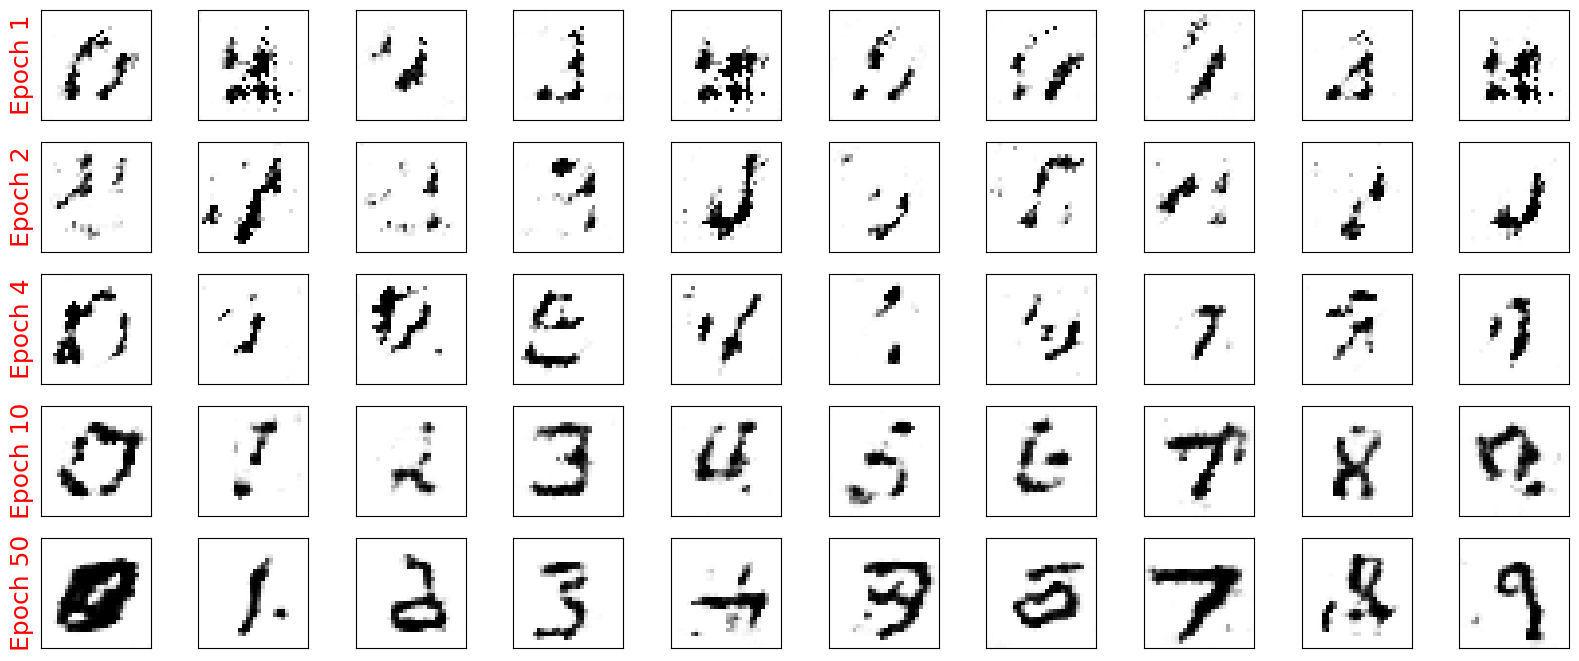

In [ ]:
 selected_epochs = [1, 2, 4, 10, 50]
fig = plt.figure(figsize=(20, 10))
for i,e in enumerate(selected_epochs):
    for j in range(10):
        ax = fig.add_subplot(6, 10, i*10+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()

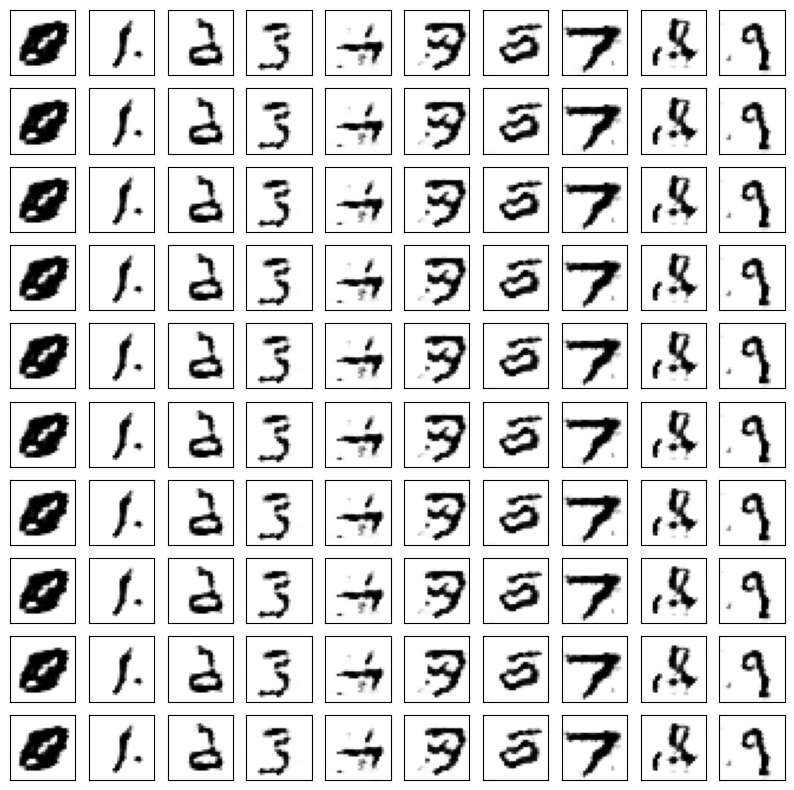

In [ ]:
## We can as well test for a few 10 random images

fixed_z = create_noise(n_classes*10, z_size, mode_z).to(device)
fixed_labels = torch.arange(n_classes).repeat(10).to(device)

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    image = create_samples(gen_model, fixed_labels[i:i+1], fixed_z[i:i+1], 1)[0]
    ax.imshow(image.detach().cpu().numpy(), cmap='gray_r')

plt.show()


#### Practical Considerations

#### **Stabilizing Training**

GANs are notoriously difficult to train due to instability and mode collapse. Here are some techniques to stabilize training:

- **Label Smoothing:** Use soft labels for the Discriminator (e.g., replace 1 with 0.9 for real images).

- **Feature Matching:** Modify the Generator's loss to match features from intermediate layers of the Discriminator.

- **Gradient Penalty:** Add a penalty term to the Discriminator's loss to enforce Lipschitz continuity.

##### **Loss Function Variations**

- **Least Squares GAN (LSGAN):**

  - **Discriminator Loss:**

$$
\mathcal{L}_D = \frac{1}{2} \mathbb{E}_{x \sim p_{\text{data}}(x)} [(D(x | y) - 1)^2] + \frac{1}{2} \mathbb{E}_{z \sim p_z(z)} [D(G(z | y) | y)^2]
$$

  - **Generator Loss:**

$$
\mathcal{L}_G = \frac{1}{2} \mathbb{E}_{z \sim p_z(z)} [(D(G(z | y) | y) - 1)^2]
$$

- **Wasserstein GAN (WGAN):**

  - Introduces the Wasserstein distance as a measure of divergence.
  - **Discriminator (Critic) Loss:**

$$
\mathcal{L}_D = \mathbb{E}_{x \sim p_{\text{data}}(x)} [D(x | y)] - \mathbb{E}_{z \sim p_z(z)} [D(G(z | y) | y)]
$$

  - **Generator Loss:**

$$
\mathcal{L}_G = -\mathbb{E}_{z \sim p_z(z)} [D(G(z | y) | y)]
$$

##### **Conditioning Methods**

- **Concatenation:** Concatenate the conditioning variable $ y $ with the input at the input layer.

- **Projection:** Use projection-based methods to incorporate $ y $ within the Discriminator.

##### **Implementation Tips**

- **Batch Normalization:** Apply carefully, considering the conditioning variables.

- **Learning Rates:** Use different learning rates for $ G $ and $ D $.

- **Optimizer Choice:** Adam optimizer is commonly used with carefully tuned hyperparameters.

---

### Summary

Check out the extensive list of GAN from this interesting [repository](https://github.com/hindupuravinash/the-gan-zoo)